# 🚗 Sistema Inteligente de Análise de Tráfego

## 📋 Descrição do Projeto
Este projeto implementa um sistema inteligente para análise de tráfego veicular utilizando visão computacional e algoritmos de rastreamento. O sistema é capaz de:

-  Detectar e rastrear veículos em tempo real
-  Contar veículos que passam por uma linha de referência
-  Identificar o estado do semáforo (verde, amarelo, vermelho)
-  Detectar infrações de trânsito (avanço no sinal vermelho)
-  Gerar relatórios estatísticos completos

## 🛠️ Tecnologias Utilizadas
- **OpenCV**: Processamento de imagens e vídeos
- **YOLO v11**: Detecção de objetos em tempo real
- **ByteTrack**: Rastreamento de objetos multi-frame
- **NumPy & Pandas**: Manipulação e análise de dados
- **Matplotlib & Seaborn**: Visualização de dados

---

## 🚀 Instalação Rápida

### 📦 Pré-requisitos
- Python 3.8 ou superior
- Git

### ⚡ Instalação
```bash
# 1. Clone o repositório
git clone https://github.com/Eduardocin/Smart-Traffic-Vehicle-Counter.git
cd Smart-Traffic-Vehicle-Counter

# 2. Crie um ambiente virtual
python -m venv venv

# 3. Ative o ambiente virtual
# Windows:
venv\Scripts\activate
# macOS/Linux:
source venv/bin/activate

# 4. Instale as dependências
pip install -r requirements.txt
```

> 📖 **Para instruções detalhadas de instalação, consulte o arquivo [`INSTALL.md`](INSTALL.md)**

---

## 🎯 Configuração do Ambiente

### 📋 Dependências Principais
As seguintes dependências são instaladas automaticamente pelo `requirements.txt`:

- `opencv-python-headless` - Processamento de imagens
- `ultralytics` - Biblioteca YOLO v11
- `numpy` - Computação numérica
- `pandas` - Análise de dados
- `matplotlib` - Visualização
- `seaborn` - Gráficos estatísticos
- `torch` - PyTorch para deep learning

### 🔧 Arquivos de Configuração Disponíveis
- `requirements.txt` - Dependências principais
- `requirements-dev.txt` - Dependências de desenvolvimento
- `environment.yml` - Configuração para Conda
- `setup.py` - Instalação como pacote Python

---

## 📞 Contato

Para dúvidas ou sugestões, entre em contato:

- **Eduardo** - ehss@cin.ufpe
- **GitHub**: https://github.com/Eduardocin
- **Repositório**: https://github.com/Eduardocin/Smart-Traffic-Vehicle-Counter


In [ ]:
!pip install opencv-python-headless numpy matplotlib ultralytics


In [1]:
import cv2
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ultralytics.trackers.byte_tracker import BYTETracker
from ultralytics import YOLO
from datetime import timedelta


# 📹 Carregamento e Visualização do Vídeo

##  Configuração dos Caminhos
Definimos os caminhos para o vídeo de entrada e pasta de saída dos resultados.

In [ ]:
video_path = 'Data/tr.mp4.crdownload'
output_path = '/content/drive/MyDrive/Voxar/Output'


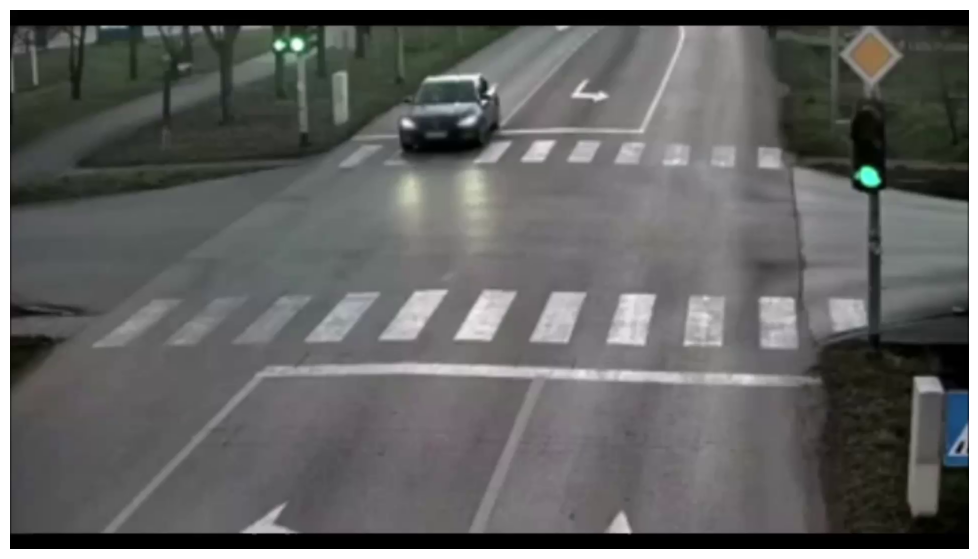

In [6]:
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
else:
    ret, frame = cap.read()
    if ret:
        plt.figure(figsize=(14, 7))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Erro ao ler o vídeo.")

cap.release()

# 📏 Definição da Linha de Contagem

##  Configuração da Zona de Detecção
A linha de contagem é posicionada estrategicamente no frame para capturar os veículos que atravessam a região de interesse. Esta linha servirá como referência para:

- Contar veículos que passam pela área
- Determinar a direção do movimento
- Identificar infrações de trânsito


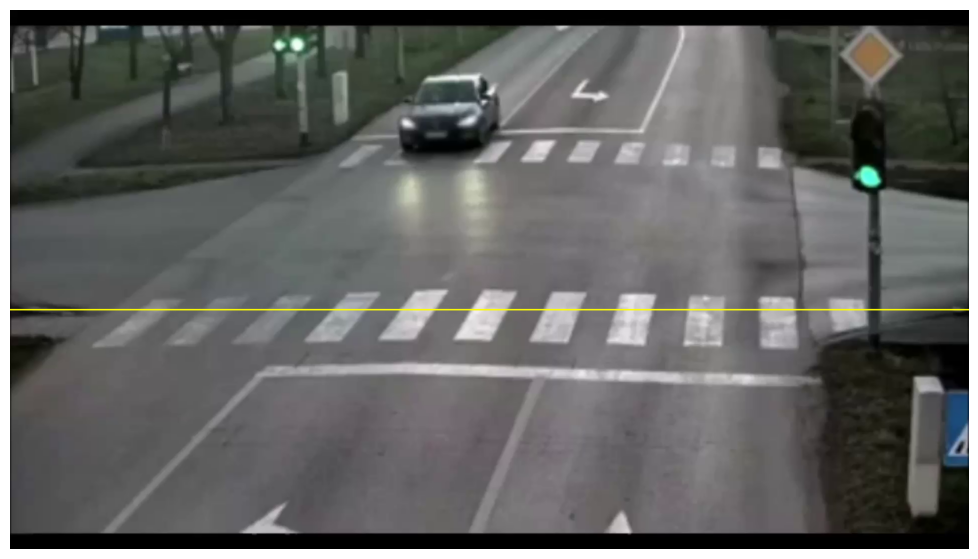

In [16]:
cap = cv2.VideoCapture(video_path)
line_y = 600

if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
else:
    ret, frame = cap.read()
    if ret:
        cv2.line(frame, (0, line_y), (frame.shape[1], line_y), (0, 255, 255), 2)
        plt.figure(figsize=(14, 7))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Erro ao ler o vídeo.")

cap.release()

# 🤖 Carregamento do Modelo YOLO

## 🧠 Inicialização do Modelo de Detecção
Carregamos o modelo YOLO v11 (versão small) que será responsável por:

- 🚗 Detectar veículos (carros, motos, caminhões)
- 👥 Identificar pessoas
- 🚦 Reconhecer semáforos
- 📦 Localizar outros objetos de interesse no tráfego

In [11]:
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 118MB/s] 


# 🎬 Processamento de Vídeo - Efeito Câmera Lenta

## ⏱️ Aplicação de Slow Motion
Para melhorar a precisão da detecção em momentos críticos, aplicamos um efeito de câmera lenta em uma seção específica do vídeo.

### 🎯 Configurações:
- **Fator de redução**: 2x mais lento
- **Intervalo de aplicação**: Frames 160 a 300
- **Objetivo**: Melhorar a precisão da detecção em momentos de maior fluxo





In [14]:
input_path = video_path
output_slow = output_path + '/video_slow.mp4'

# Fator de câmera lenta
slow_factor = 2


cap = cv2.VideoCapture(input_path)

# Define o codec e cria o objeto de escrita do vídeo de saída
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_slow, fourcc, fps, (width, height))

frame_number = 0  # Contador de frames

# processar cada frame do vídeo
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Aplica câmera lenta duplicando os frames entre 160 e 300
    if 160 <= frame_number <= 300:
        for _ in range(slow_factor):
            out.write(frame)
    else:
        out.write(frame)

    frame_number += 1

cap.release()
out.release()


# 🎯 Rastreamento de Objetos com YOLO + ByteTrack

## 🔍 Detecção e Rastreamento Inteligente
Utilizamos a combinação do YOLO v11 com o algoritmo ByteTrack para:

- 🎯 **Detecção**: Identificar objetos frame a frame
- 🔄 **Rastreamento**: Manter IDs únicos para cada objeto
- 📊 **Continuidade**: Seguir objetos ao longo do vídeo
- 🎮 **Parâmetros**: Confiança 0.25 e IoU 0.3 para otimizar precisão


In [ ]:
results = model.track(source=output_slow, conf=0.25, iou=0.3, tracker="bytetrack.yaml")

# 📊 Classificação e Contagem de Veículos

## 🎯 Sistema Principal de Análise
Esta seção implementa o núcleo do sistema, realizando:

- 🚗 **Contagem de veículos** que cruzam a linha de referência
- 🚦 **Detecção do estado do semáforo** (verde, amarelo, vermelho)
- 🚨 **Identificação de infrações** (avanço no sinal vermelho)
- 📝 **Geração de relatórios** em CSV
- 🎬 **Criação de vídeo** com as anotações

### 📋 Configuração Inicial
Definimos os parâmetros para o vídeo de saída e relatórios.

In [17]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
csv_path = output_path + '/relatorio_veiculos.csv'
out = cv2.VideoWriter(output_path + '/resultado_yolov11_bytetrack_tr.mp4', fourcc, fps, (width, height))

# ⚙️ Inicialização de Variáveis e Parâmetros

## 🎛️ Configuração dos Parâmetros de Controle
Definimos as variáveis principais que controlam o sistema de análise:

- 📊 **Controle de eventos**: Lista para armazenar todas as detecções
- 📏 **Linha de contagem**: Posição Y=600 para detecção
- 🔢 **Contadores**: Variáveis para contagem de veículos
- 🆔 **Rastreamento**: Controle de IDs já contabilizados
- 📍 **Posicionamento**: Histórico de posições para análise de direção



In [18]:
eventos = []
line_y = 600
vehicle_count = 0
counted_ids = set()
frame_number = 0
posicoes_anteriores = {}

# 🎬 Processamento Principal dos Frames

## 🔄 Loop Principal de Análise
Esta célula contém o algoritmo principal que processa cada frame do vídeo:

### 🎯 Funcionalidades Implementadas:
- 🎨 **Desenho da linha de referência** no frame
- 🔍 **Processamento de detecções** do YOLO
- 🎨 **Colorização por classe**: Pessoa (branco), Carro (verde), Semáforo (vermelho)
- 📊 **Lógica de contagem** com controle de IDs únicos
- 🚦 **Análise de cor do semáforo** usando HSV
- 🚨 **Detecção de infrações** baseada em direção e estado do semáforo
- 📝 **Overlay de informações** no vídeo (contagem, estado do semáforo)
- 💾 **Geração de relatório CSV** com todos os eventos

In [19]:
for result in results:
    frame_number += 1
    frame = result.orig_img.copy()
    height, width = frame.shape[:2]

    # Desenha a linha de referência
    cv2.line(frame, (0, line_y), (width, line_y), (0, 255, 255), 2)

    traffic_light_state = "Verde"

    # Verificação de Detecções no Frame
    if hasattr(result, "boxes") and result.boxes is not None:
        boxes = result.boxes.xyxy.cpu().numpy()
        track_ids = result.boxes.id.int().cpu().numpy() if result.boxes.id is not None else []
        min_length = min(len(boxes), len(track_ids))
        boxes = boxes[:min_length]
        track_ids = track_ids[:min_length]

        color_map = {
            0: (255, 255, 255),   # pessoa
            2: (0, 255, 0),       # carro
            9: (0, 0, 255)        # semáforo
        }

        #  Processamento de Cada Objeto Detectado
        for i, box in enumerate(boxes):
            track_id = track_ids[i]
            x1, y1, x2, y2 = map(int, box[:4])
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)

            # Verifica a direção do movimento
            pos_anterior = posicoes_anteriores.get(track_id, cy)
            direcao = "baixo" if cy > pos_anterior else "cima"
            posicoes_anteriores[track_id] = cy

            cls_idx = int(result.boxes.cls[i])
            class_name = model.names[cls_idx] if hasattr(model, "names") else str(cls_idx)

            color = color_map.get(cls_idx, (0, 255, 255))
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label = f"{class_name}"
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
            cv2.rectangle(frame, (x1, y1 - h - 10), (x1 + w, y1), (0, 0, 0), -1)
            cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            cv2.circle(frame, (cx, cy), 5, color, -1)

            # Lógica de Contagem e Multa
            if (
                cls_idx == 2 and
                track_id not in counted_ids and
                abs(cy - line_y) < 15
            ):
                vehicle_count += 1
                counted_ids.add(track_id)

                esta_multado = (direcao == "cima" and traffic_light_state == "Vermelho")

                eventos.append({
                    'frame': frame_number,
                    'vehicle_id': int(track_id),
                    'traffic_light': traffic_light_state,
                    'direcao': direcao,
                    'multado': esta_multado
                })

                if esta_multado:
                    cv2.putText(frame, "MULTADO!", (x1, y1-25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            #  Detecção da Cor do Semáforo
            if cls_idx == 9:  # traffic light
                roi = frame[y1:y2, x1:x2]
                if roi.size > 0:
                    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
                    mask_red1 = cv2.inRange(hsv, (0, 70, 50), (10, 255, 255))
                    mask_red2 = cv2.inRange(hsv, (170, 70, 50), (180, 255, 255))
                    mask_red = cv2.bitwise_or(mask_red1, mask_red2)
                    mask_green = cv2.inRange(hsv, (40, 40, 40), (90, 255, 255))
                    red_pixels = cv2.countNonZero(mask_red)
                    green_pixels = cv2.countNonZero(mask_green)

                    if red_pixels > green_pixels and red_pixels > 10:
                        traffic_light_state = "Vermelho"
                    elif green_pixels > red_pixels and green_pixels > 10:
                        traffic_light_state = "Verde"
                    else:
                        traffic_light_state = "Amarelo"

            #  Sobreposição de Texto na Tela
            font_scale = 2
            y_position = 80
            thickness = 2
            font = cv2.FONT_HERSHEY_SIMPLEX

            label_count = f"Contagem de Veiculos: {vehicle_count}"
            (count_width, text_height), _ = cv2.getTextSize(label_count, font, font_scale, thickness)

            text_semaforo = f"Sinal: {traffic_light_state}"
            (semaforo_width, _), _ = cv2.getTextSize(text_semaforo, font, font_scale, thickness)

            x_semaforo = width - semaforo_width - 30
            padding = 10

            cv2.rectangle(frame,
                          (5, y_position - text_height - padding),
                          (15 + count_width, y_position + padding),
                          (0, 0, 0), -1)
            cv2.rectangle(frame,
                          (x_semaforo - padding, y_position - text_height - padding),
                          (x_semaforo + semaforo_width + padding, y_position + padding),
                          (0, 0, 0), -1)

            cv2.putText(frame, label_count, (10, y_position),
                        font, font_scale, (0, 255, 0), thickness)

            cv2.putText(frame, text_semaforo, (x_semaforo, y_position),
                        font, font_scale,
                        (0, 0, 255) if traffic_light_state == "Vermelho" else (0, 255, 0),
                        thickness)

    out.write(frame)

#  Liberação dos Recursos e Escrita no CSV
cap.release()
out.release()
cv2.destroyAllWindows()

with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['frame', 'vehicle_id', 'traffic_light', 'direcao', 'multado']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for evento in eventos:
        writer.writerow(evento)

print(f"Vídeo salvo como resultado_yolov11_bytetrack_tr.mp4\nTotal de veículos: {vehicle_count}")


Vídeo salvo como resultado_yolov11_bytetrack_tr.mp4
Total de veículos: 5


In [25]:
df = pd.read_csv(output_path + '/relatorio_veiculos.csv')
fps = 30

# Convertendo frames para tempo
if 'frame' in df.columns and pd.api.types.is_numeric_dtype(df['frame']) and not df['frame'].isna().all():
    df['tempo'] = df['frame'].apply(lambda x: timedelta(seconds=x/fps) if pd.notna(x) else pd.NaT)


# ------------ ANÁLISES ESTATÍSTICAS ------------

# Análise básica
carros_total = len(df)
multados = df[df['multado'] == True]
taxa_infração = len(multados) / carros_total * 100 if carros_total > 0 else 0

# Análise por estado do semáforo
fluxo_por_estado = df['traffic_light'].value_counts()
percentual_por_estado = df['traffic_light'].value_counts(normalize=True) * 100

# Análise temporal
tempo_medio_entre_veiculos = None
media_fluxo = None
mediana_fluxo = None
max_fluxo = None
min_fluxo = None
std_fluxo = None
pico_momento = None
variabilidade = None

if 'frame' in df.columns and pd.api.types.is_numeric_dtype(df['frame']) and not df['frame'].isna().all():

    df['intervalo'] = df['frame'].apply(lambda x: int(x/fps/10)*10 if pd.notna(x) else -1)
    fluxo_por_intervalo = df[df['intervalo'] >= 0].groupby('intervalo').size()
    if not fluxo_por_intervalo.empty:
        media_fluxo = fluxo_por_intervalo.mean()
        mediana_fluxo = fluxo_por_intervalo.median()
        max_fluxo = fluxo_por_intervalo.max()
        min_fluxo = fluxo_por_intervalo.min()
        std_fluxo = fluxo_por_intervalo.std() if len(fluxo_por_intervalo) > 1 else 0
        pico_momento = fluxo_por_intervalo.idxmax()
        if media_fluxo and media_fluxo > 0 and std_fluxo is not None:
             variabilidade = std_fluxo / media_fluxo * 100

    # Calcule intervalos entre veículos
    if len(df) > 1:
        df_sorted = df.dropna(subset=['frame']).sort_values('frame')
        if len(df_sorted) > 1:
             df_sorted['intervalo_veiculos'] = df_sorted['frame'].diff()
             tempo_medio_entre_veiculos = df_sorted['intervalo_veiculos'].iloc[1:].mean() / fps


# ------------ CRIAÇÃO DO RELATÓRIO ------------

print("\n--- RELATÓRIO DE ANÁLISE DE FLUXO DE TRÁFEGO ---\n")

print("📊 ESTATÍSTICAS GERAIS")
print(f"   - Total de veículos detectados: {carros_total}")
print(f"   - Taxa de infrações (semáforo vermelho): {taxa_infração:.1f}%")
if tempo_medio_entre_veiculos is not None:
    print(f"   - Tempo médio entre veículos: {tempo_medio_entre_veiculos:.2f} segundos")

print("\n📈 FLUXO POR ESTADO DO SEMÁFORO")
if not fluxo_por_estado.empty:
    for estado, contagem in fluxo_por_estado.items():
        percentual = percentual_por_estado.get(estado, 0)
        print(f"   - {str(estado).capitalize()}: {contagem} veículos ({percentual:.1f}%)")


if media_fluxo is not None:
    print("\n⏱️ ANÁLISE TEMPORAL (Intervalos de 10s)")
    print(f"   - Fluxo médio: {media_fluxo:.2f} veículos/intervalo")
    print(f"   - Fluxo (min-max): {min_fluxo}-{max_fluxo} veículos/intervalo")
    if std_fluxo is not None:
        print(f"   - Desvio padrão do fluxo: {std_fluxo:.2f}")
    if pico_momento is not None:
        print(f"   - Pico de fluxo entre: {pico_momento}s - {pico_momento + 10}s ({max_fluxo} veículos)")


print("\n🚨 VEÍCULOS MULTADOS (AVANÇO NO VERMELHO)")
if not multados.empty:
    multados_sorted = multados.sort_values('frame') if 'frame' in multados.columns else multados
    for _, row in multados_sorted.iterrows():
        frame_num = int(row['frame']) if 'frame' in row and pd.notna(row['frame']) else 'N/A'
        frame_time_str = str(timedelta(seconds=row['frame']/fps)).split('.')[0] if 'frame' in row and pd.notna(row['frame']) else "tempo desconhecido" # Format time H:MM:SS
        print(f"   - ID {int(row['vehicle_id'])} | Frame: {frame_num} | Tempo aprox.: {frame_time_str}")


print("\n🔎 INSIGHTS")
if not fluxo_por_estado.empty:
    estado_mais_comum = fluxo_por_estado.idxmax()
    print(f"   - Estado do semáforo com maior fluxo: {str(estado_mais_comum).capitalize()}")

if taxa_infração > 10:
    print(f"   - ALERTA: Alta taxa de infrações ({taxa_infração:.1f}%). Considerar revisão de tempo ou fiscalização.")
elif taxa_infração > 0:
    print(f"   - Taxa de infrações ({taxa_infração:.1f}%) presente, mas moderada.")


if variabilidade is not None:
    if variabilidade > 60:
        print(f"   - Fluxo de veículos apresentou alta variabilidade ({variabilidade:.1f}%).")
    elif variabilidade > 30:
        print(f"   - Fluxo de veículos apresentou variabilidade moderada ({variabilidade:.1f}%).")
    else:
        print(f"   - Fluxo de veículos relativamente estável ({variabilidade:.1f}%).")




--- RELATÓRIO DE ANÁLISE DE FLUXO DE TRÁFEGO ---

📊 ESTATÍSTICAS GERAIS
   - Total de veículos detectados: 5
   - Taxa de infrações (semáforo vermelho): 20.0%
   - Tempo médio entre veículos: 3.85 segundos

📈 FLUXO POR ESTADO DO SEMÁFORO
   - Verde: 3 veículos (60.0%)
   - Vermelho: 2 veículos (40.0%)

⏱️ ANÁLISE TEMPORAL (Intervalos de 10s)
   - Fluxo médio: 2.50 veículos/intervalo
   - Fluxo (min-max): 2-3 veículos/intervalo
   - Desvio padrão do fluxo: 0.71
   - Pico de fluxo entre: 0s - 10s (3 veículos)

🚨 VEÍCULOS MULTADOS (AVANÇO NO VERMELHO)
   - ID 34 | Frame: 520 | Tempo aprox.: 0:00:17

🔎 INSIGHTS
   - Estado do semáforo com maior fluxo: Verde
   - ALERTA: Alta taxa de infrações (20.0%). Considerar revisão de tempo ou fiscalização.
   - Fluxo de veículos relativamente estável (28.3%).


# 🎯 Conclusões e Próximos Passos

## ✅ Resultados Obtidos
O sistema implementado demonstra capacidade de:

-  **Detecção precisa** de veículos em movimento
-  **Contagem automática** com controle de IDs únicos
-  **Reconhecimento de semáforos** por análise de cor
-  **Detecção de infrações** em tempo real
-  **Geração de relatórios** estatísticos completos

##  Melhorias Futuras
### 🛠️ Otimizações Técnicas:
-   Calibração automática da linha de contagem
-   Melhoria na detecção de cores do semáforo
-   Implementação de diferentes tipos de veículos
-   Interface web para monitoramento em tempo real

### 📊 Funcionalidades Adicionais:
-   Classificação por tipo de veículo (carro, moto, caminhão)
-   Estimativa de velocidade dos veículos
-   Análise de eficiência semafórica
-   Alertas automáticos para infrações

## 🎓 Considerações Finais
Este projeto demonstra o potencial da visão computacional aplicada ao controle de tráfego, oferecendo uma solução automatizada para monitoramento e análise de fluxo veicular.

---

*Desenvolvido utilizando Python, OpenCV, YOLO v11 e ByteTrack*